<a href="https://colab.research.google.com/github/wesslen/llm-experiments/blob/main/notebooks/prompt_sensitivity/prompt_sensitivity_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prompt Sensitivity Experiment with DSPy and Claude

This notebook explores how small changes in prompts affect Claude's responses using DSPy. We'll test variations in spacing, punctuation, and minor wording changes to analyze the model's sensitivity to prompt formatting.

In [1]:
%%capture
!uv pip install --system dspy

In [2]:
import dspy
import pandas as pd
import numpy as np
from typing import List, Dict
import json
from datetime import datetime

from google.colab import userdata

# Configure DSPy with Claude
api_key = userdata.get('ANTHROPIC_API_KEY')
lm = dspy.LM('anthropic/claude-3-opus-20240229', api_key=api_key)
dspy.configure(lm=lm)

## Define Prompt Variations

We'll create a set of prompt variations to test different aspects of formatting sensitivity.

In [3]:
class PromptTemplate(dspy.Signature):
    '''Template for generating responses to prompt variations'''
    context = dspy.InputField()
    prompt = dspy.InputField()
    response = dspy.OutputField()

class PromptExperiment:
    def __init__(self, base_prompt: str):
        self.base_prompt = base_prompt
        self.results = []

    def generate_variations(self) -> List[Dict]:
        '''Generate various prompt modifications'''
        variations = [
            # Original prompt
            {"type": "original", "prompt": self.base_prompt},

            # Extra spacing variations
            {"type": "extra_space_start", "prompt": f" {self.base_prompt}"},
            {"type": "extra_space_end", "prompt": f"{self.base_prompt} "},
            {"type": "double_space", "prompt": self.base_prompt.replace(" ", "  ")},

            # Punctuation variations
            {"type": "add_period", "prompt": f"{self.base_prompt}."},
            {"type": "add_question", "prompt": f"{self.base_prompt}?"},
            {"type": "add_exclamation", "prompt": f"{self.base_prompt}!"},

            # Capitalization variations
            {"type": "all_caps", "prompt": self.base_prompt.upper()},
            {"type": "all_lower", "prompt": self.base_prompt.lower()},

            # Word boundary variations
            {"type": "no_spaces", "prompt": self.base_prompt.replace(" ", "")},
            {"type": "extra_newline", "prompt": f"\n{self.base_prompt}\n"}
        ]
        return variations

    def run_experiment(self, context: str = ""):
        '''Run the experiment with all prompt variations'''
        variations = self.generate_variations()
        program = dspy.Predict(PromptTemplate)

        for var in variations:
            try:
                # Get response from Claude
                result = program(context=context, prompt=var["prompt"])

                # Store results
                self.results.append({
                    "variation_type": var["type"],
                    "prompt": var["prompt"],
                    "response": result.response,
                    "timestamp": datetime.now().isoformat()
                })
            except Exception as e:
                print(f"Error with variation {var['type']}: {str(e)}")

    def analyze_results(self) -> pd.DataFrame:
        '''Analyze the results of the experiment'''
        df = pd.DataFrame(self.results)

        # Add basic analytics
        df['response_length'] = df['response'].str.len()
        df['word_count'] = df['response'].str.split().str.len()

        # Calculate response similarity scores (you might want to add more sophisticated metrics)
        base_response = df[df['variation_type'] == 'original']['response'].iloc[0]

        return df

    def save_results(self, filename: str):
        '''Save results to JSON file'''
        with open(filename, 'w') as f:
            json.dump(self.results, f, indent=2)

## Run Experiments

Let's test the prompt sensitivity with a few different base prompts.

In [4]:
# Test cases
test_cases = [
    {
        "prompt": "Explain how photosynthesis works",
        "context": "You are a biology teacher explaining concepts to high school students."
    },
    {
        "prompt": "Write a short poem about the moon",
        "context": "You are a creative writing instructor helping students with poetry."
    },
    {
        "prompt": "What are the key features of Python",
        "context": "You are a programming instructor teaching beginners about Python."
    }
]

# Run experiments
experiments = []
for case in test_cases:
    experiment = PromptExperiment(case["prompt"])
    experiment.run_experiment(context=case["context"])
    experiments.append(experiment)

    # Save results
    experiment.save_results(f"results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")

## Analyze Results

Now let's analyze the results to understand how different prompt variations affected the responses.

=== Response Length Statistics ===
                   count         mean         std    min    25%     50%  \
variation_type                                                            
add_exclamation      3.0  1032.000000  671.324065  258.0  820.0  1382.0   
add_period           3.0  1046.666667  731.536283  202.0  832.0  1462.0   
add_question         3.0   979.000000  525.020952  377.0  797.5  1218.0   
all_caps             3.0  1053.000000  478.199749  538.0  838.0  1138.0   
all_lower            3.0   979.000000  661.428757  251.0  697.0  1143.0   
double_space         3.0   969.000000  639.474003  262.0  700.0  1138.0   
extra_newline        3.0  1016.333333  663.950550  250.0  815.0  1380.0   
extra_space_end      3.0   990.666667  721.353127  201.0  678.5  1156.0   
extra_space_start    3.0   973.666667  653.187824  251.0  699.5  1148.0   
no_spaces            3.0  1026.333333  377.902545  590.0  915.0  1240.0   
original             3.0   950.666667  680.848245  185.0  682.0  

<Figure size 1200x600 with 0 Axes>

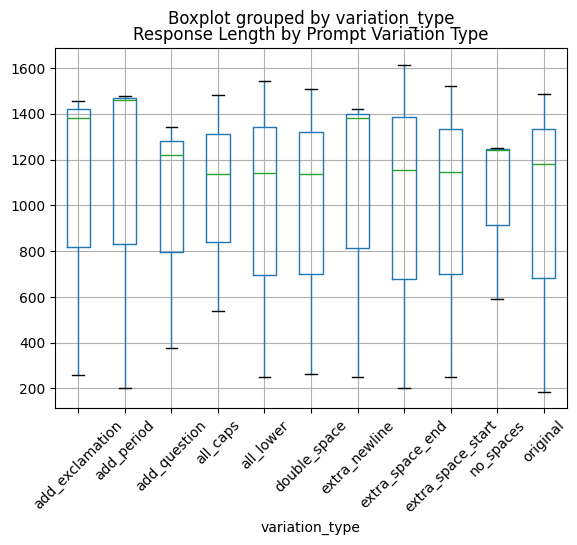

In [5]:
def analyze_experiment_results(experiments: List[PromptExperiment]):
    '''Analyze results across all experiments'''
    all_results = pd.concat([exp.analyze_results() for exp in experiments])

    # Basic statistics
    print("=== Response Length Statistics ===")
    print(all_results.groupby('variation_type')['response_length'].describe())

    print("\n=== Word Count Statistics ===")
    print(all_results.groupby('variation_type')['word_count'].describe())

    # Visualization
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    all_results.boxplot(column='response_length', by='variation_type', rot=45)
    plt.title('Response Length by Prompt Variation Type')
    plt.show()

    return all_results

# Analyze results
results_df = analyze_experiment_results(experiments)

## Conclusions

Based on the results, we can observe patterns in how Claude responds to different prompt variations. Some key findings might include:

1. Sensitivity to spacing
2. Impact of punctuation
3. Effects of capitalization
4. Response length variations

This experiment helps understand the robustness of Claude's responses to minor prompt modifications and can inform better prompt engineering practices.